In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from default_func import extract_image_file_name_from_lidar_file_name, extract_bboxes_file_name_from_image_file_name

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from os.path import join
import glob

root_path_train = '.\\camera_lidar_semantic_bboxes\\train\\'
# get the list of files in lidar directory
file_names_lidar_train = sorted(glob.glob(join(root_path_train, '*\\lidar\\cam_front_center\\*.npz')))

root_path_test = '.\\camera_lidar_semantic_bboxes\\test\\'
# get the list of files in lidar directory
file_names_lidar_test = sorted(glob.glob(join(root_path_test, '*\\lidar\\cam_front_center\\*.npz')))

file_names_photo_train = []

for file_name_lidar in file_names_lidar_train:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_train, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_train.append(file_name_image)

file_names_photo_test = []

for file_name_lidar in file_names_lidar_test:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_test, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_test.append(file_name_image)

file_names_bboxes_train = []

for file_name_image, file_name_lidar in zip(file_names_photo_train, file_names_lidar_train):
    seq_name = file_name_lidar.split('\\')[3]
    file_name_bboxes = extract_bboxes_file_name_from_image_file_name(file_name_image)
    file_name_bboxes = join(root_path_train, seq_name, 'label3D\\cam_front_center\\', file_name_bboxes)
    file_names_bboxes_train.append(file_name_bboxes)

file_names_bboxes_test = []

for file_name_image, file_name_lidar in zip(file_names_photo_test, file_names_lidar_test):
    seq_name = file_name_lidar.split('\\')[3]
    file_name_bboxes = extract_bboxes_file_name_from_image_file_name(file_name_image)
    file_name_bboxes = join(root_path_test, seq_name, 'label3D\\cam_front_center\\', file_name_bboxes)
    file_names_bboxes_test.append(file_name_bboxes)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from default_func import read_bounding_boxes_2d

def resize_bboxes(bboxes, original_size, target_size):
    """
    Масштабирует bounding box'ы при изменении размера изображения.
    
    Args:
        bboxes (torch.Tensor): Тензор размером [N, 4] с координатами [left, top, right, bottom]
        original_size (tuple): Исходный размер изображения (width, height)
        target_size (tuple): Целевой размер изображения (width, height)
    
    Returns:
        torch.Tensor: Масштабированные bounding box'ы размером [N, 4]
    """
    orig_w, orig_h = original_size  # <- ИЗМЕНИЛОСЬ: (width, height)
    target_w, target_h = target_size  # <- ИЗМЕНИЛОСЬ: (width, height)
    
    # Вычисляем коэффициенты масштабирования
    scale_x = target_w / orig_w
    scale_y = target_h / orig_h
    
    # Создаем копию тензора для избежания изменения оригинальных данных
    scaled_bboxes = bboxes.clone().float()
    
    # Масштабируем координаты
    scaled_bboxes[:, 0] *= scale_x  # left
    scaled_bboxes[:, 1] *= scale_y  # top
    scaled_bboxes[:, 2] *= scale_x  # right
    scaled_bboxes[:, 3] *= scale_y  # bottom
    
    return scaled_bboxes

class DetectionDataset(Dataset):
    def __init__(self, image_files, bbox_files, image_size=(300, 300), output_format="SSD"):
        self.image_files = image_files
        self.bbox_files = bbox_files
        self.image_size = image_size  # (height, width)
        self.output_format = output_format

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Загружаем картинку
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        original_size = img.size  # (width, height)
        
        # Загружаем боксы
        target = read_bounding_boxes_2d(self.bbox_files[idx], original_size, output_format=self.output_format)
        
        # Сохраняем оригинальный размер для дебаггинга
        target['original_size'] = torch.tensor(original_size)
        
        # Преобразуем картинку
        img_transformed = self.transform(img)
        transformed_size = (img_transformed.shape[2], img_transformed.shape[1])  # (width, height)
        
        # Масштабируем боксы
        target['boxes'] = resize_bboxes(target['boxes'], original_size, transformed_size).to(device)
        #target['boxes'] = target['boxes'].to(device)
        target['labels'] = target['labels'].to(device)
        
        return img_transformed, target


# collate_fn для DataLoader
def collate_fn(batch):
    images = [item[0] for item in batch]   # список тензоров картинок
    images = torch.stack(images, dim=0).to(device)
    targets = [item[1] for item in batch]  # список словарей с боксами
    return images, targets


# Пример использования
train_dataset = DetectionDataset(file_names_photo_train, file_names_bboxes_train, image_size=(300, 300))
test_dataset  = DetectionDataset(file_names_photo_test, file_names_bboxes_test, image_size=(300, 300))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [ ]:
import torchvision.ops as ops
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F

def apply_nms(predictions, iou_threshold=0.5, score_threshold=0.5):
    """
    Применяет Non-Maximum Suppression (NMS) к предсказаниям SSD.

    predictions: словарь с ключами 'boxes', 'labels', 'scores'
    iou_threshold: порог IoU для удаления дубликатов
    score_threshold: минимальная уверенность, с которой бокс считается валидным
    """
    result = []
    for predict in predictions:
        boxes = predict['boxes']
        scores = predict['scores']
        labels = predict['labels']

        # Оставляем только боксы с высокой уверенностью
        keep = scores > score_threshold
        boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

        # Применяем NMS
        keep_indices = ops.nms(boxes, scores, iou_threshold)

        result.append({
            'boxes': boxes[keep_indices],
            'labels': labels[keep_indices],
            'scores': scores[keep_indices]
        })

    return result

def visualize_batch_ssd(images, targets, class_names=None):
    batch_size = images.shape[0]  # Количество изображений в батче
    
    
    # ImageNet стандартные параметры нормализации
    IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
    IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])
    
    batch_size = images.shape[0]
    
    for i in range(batch_size):
        # Денормализуем ImageNet
        img = images[i].cpu().clone()
        
        # Денормализация: image = (image * std) + mean
        for c in range(3):
            img[c] = img[c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
        
        # Обрезаем значения в диапазон [0, 1]
        img = torch.clamp(img, 0, 1)
        
        # Преобразуем в [0, 255] для визуализации
        img = (img * 255).byte()
        
        target = targets[i]
        boxes = target['boxes'].cpu().int()  # Достаем координаты боксов
        labels = target['labels'].cpu().tolist()  # Достаем метки классов
        scores = target['scores'].cpu().tolist()  # Достаем вероятности
        
        # Генерируем текстовые метки с учетом имен классов
        if class_names:
            labels = [f"{class_names[label]}: {score:.2f}" for label, score in zip(labels, scores)]
        else:
            labels = [f"{label}: {score:.2f}" for label, score in zip(labels, scores)]
        
        img = draw_bounding_boxes(img, boxes, labels=labels, colors="red", width=2)
        
        plt.figure(figsize=(6, 6))
        img = F.to_pil_image(img)
        plt.imshow(img)
        plt.axis("off")
        plt.show()

def visualize_batch_ssd_with_GT(images, targets, ground_truth, class_names=None, img_name = 'test_image', save = False):
    batch_size = images.shape[0]  # Количество изображений в батче
    
    
    # ImageNet стандартные параметры нормализации
    IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
    IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])
    
    batch_size = images.shape[0]
    
    for i in range(batch_size):
        # Денормализуем ImageNet
        img = images[i].cpu().clone()
        
        # Денормализация: image = (image * std) + mean
        for c in range(3):
            img[c] = img[c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
        
        # Обрезаем значения в диапазон [0, 1]
        img = torch.clamp(img, 0, 1)
        
        # Преобразуем в [0, 255] для визуализации
        img = (img * 255).byte()
        
        target = targets[i]
        boxes = target['boxes'].cpu().int()  # Достаем координаты боксов
        labels = target['labels'].cpu().tolist()  # Достаем метки классов
        scores = target['scores'].cpu().tolist()  # Достаем вероятности

        gt = ground_truth[i]
        boxes_gt = gt['boxes'].cpu().int()  # Достаем координаты боксов
        labels_gt = gt['labels'].cpu().tolist()  # Достаем метки классов
        scores_gt = gt['scores'].cpu().tolist()  # Достаем вероятности
        
        # Генерируем текстовые метки с учетом имен классов
        if class_names:
            labels = [f"{class_names[label]}: {score:.2f}" for label, score in zip(labels, scores)]
        else:
            labels = [f"{label}: {score:.2f}" for label, score in zip(labels, scores)]

        if class_names:
            labels_gt = [f"{class_names[label]}: {score:.2f}" for label, score in zip(labels_gt, scores_gt)]
        else:
            labels_gt = [f"{label}: {score:.2f}" for label, score in zip(labels_gt, scores_gt)]

        img = draw_bounding_boxes(img, boxes_gt, labels=labels_gt, colors="green", width=2)
        img = draw_bounding_boxes(img, boxes, labels=labels, colors="red", width=2)
        
        plt.figure(figsize=(6, 6))
        img = F.to_pil_image(img)
        plt.imshow(img)
        plt.axis("off")
        if save: 
            plt.savefig(f'{img_name}_{i}.png')
        else:
            plt.show()

tensor([[ 50.9310, 172.9621, 104.4278, 233.3817]], device='cuda:0')
tensor([[ 78.4002, 172.5718, 114.5123, 212.6317]], device='cuda:0')
tensor([[ 96.5992, 142.7170, 135.6053, 198.7801]], device='cuda:0')
tensor([[ 29.0596, 111.7089, 104.5112, 213.9216]], device='cuda:0')


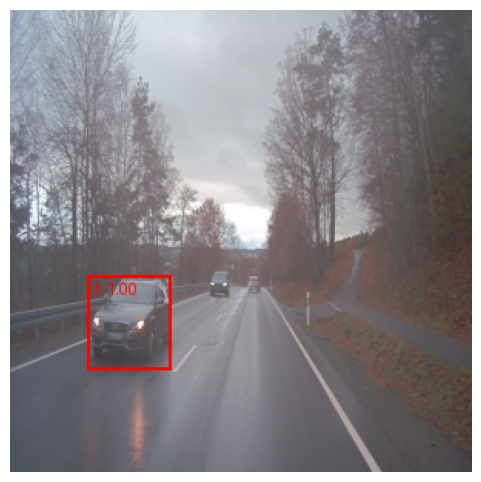

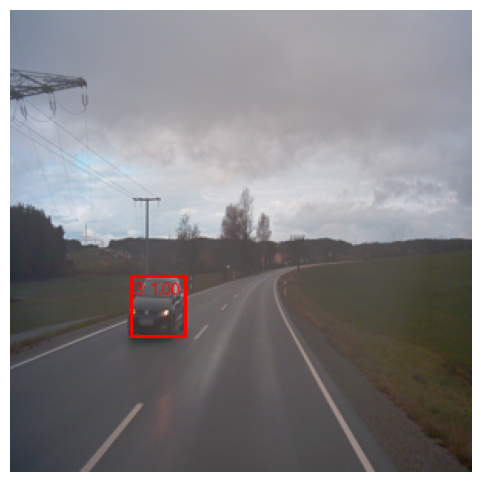

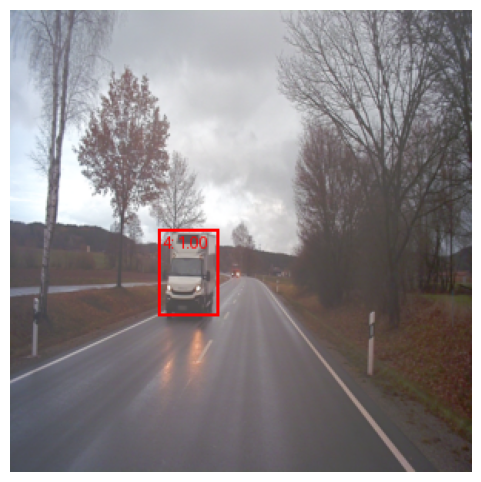

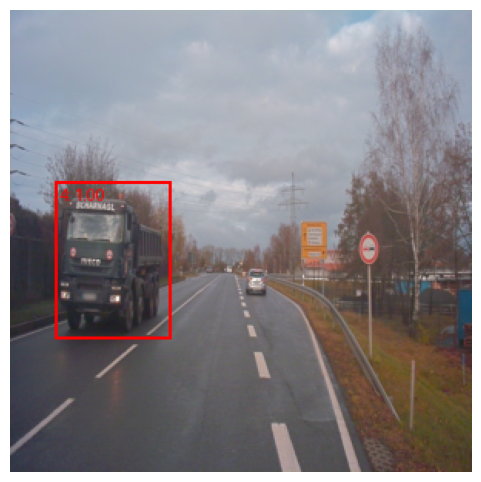

In [8]:
for images_test, targets_test in test_loader:
    #image = test_images[0].to(device)
    for target in targets_test:
        print(target['boxes'])
        n = len(target['labels'])
        target['scores'] = torch.ones(n, dtype=torch.float32)

    visualize_batch_ssd(images_test, targets_test)

    break

In [7]:
from torchvision.models.detection import ssd300_vgg16

num_classes = 6 + 1  # ваше число классов + 1 для фонового класса
model = ssd300_vgg16(weights=None, num_classes=num_classes)

In [9]:
import torch.optim.lr_scheduler as lr_scheduler

#device = 'cpu'

model = model.to(device)

# Оптимизатор
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

# Планировщик (каждые 10 эпох уменьшает lr в 2 раза)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

In [11]:
num_epochs = 40
history = []
history_test = []

In [12]:
from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_test_loss = 0

    # Прогресс-бар для обучающего цикла
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1} Train", leave=False):
        try:
            optimizer.zero_grad()
            loss_dict = model(images, targets)  # Обучение модели (SSD/Faster R-CNN выдаёт лоссы)
            loss = sum(loss for loss in loss_dict.values())

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        except:
            print('Box zeros')

    avg_train_loss = total_loss / len(train_loader)
    history.append(avg_train_loss)
    #history.append(total_loss)

    # Прогресс-бар для тестового цикла
    for images_test, targets_test in tqdm(test_loader, desc=f"Epoch {epoch+1} Test", leave=False):
        try:
            loss_dict = model(images_test, targets_test)  # Тест модели
            loss = sum(loss for loss in loss_dict.values())
            total_test_loss += loss.item()
        except:
            print('Box zeros')

    avg_test_loss = total_test_loss / len(test_loader)
    history_test.append(avg_test_loss)
    #history_test.append(total_test_loss)

    # Обновляем learning rate на основе test loss
    scheduler.step(avg_test_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

Epoch 1 Train:  59%|█████▉    | 1819/3059 [13:03<08:32,  2.42it/s]

Box zeros


Epoch 1 Train:  94%|█████████▎| 2863/3059 [20:43<01:21,  2.40it/s]

Box zeros


Epoch 1, Train Loss: 4.9082, Test Loss: 3.7352


Epoch 2 Train:  29%|██▊       | 872/3059 [06:04<13:58,  2.61it/s]

Box zeros


Epoch 2 Train:  85%|████████▌ | 2604/3059 [18:39<03:06,  2.44it/s]

Box zeros


Epoch 2, Train Loss: 3.5671, Test Loss: 3.1035


Epoch 3 Train:  65%|██████▍   | 1975/3059 [14:04<07:40,  2.35it/s]

Box zeros


Epoch 3 Train:  93%|█████████▎| 2841/3059 [20:25<01:27,  2.48it/s]

Box zeros


Epoch 3, Train Loss: 2.9710, Test Loss: 2.6739


Epoch 4 Train:  24%|██▍       | 735/3059 [05:11<15:06,  2.56it/s] 

Box zeros


Epoch 4 Train:  51%|█████▏    | 1570/3059 [11:10<10:13,  2.43it/s]

Box zeros


Epoch 4, Train Loss: 2.5899, Test Loss: 2.6369


Epoch 5 Train:  41%|████      | 1242/3059 [08:40<12:08,  2.50it/s]

Box zeros


Epoch 5 Train:  48%|████▊     | 1459/3059 [10:14<10:56,  2.44it/s]

Box zeros


Epoch 5, Train Loss: 2.2710, Test Loss: 2.6289


Epoch 6 Train:  57%|█████▋    | 1755/3059 [12:23<08:37,  2.52it/s]

Box zeros


Epoch 6 Train:  82%|████████▏ | 2512/3059 [17:52<03:48,  2.39it/s]

Box zeros


Epoch 6, Train Loss: 2.0053, Test Loss: 2.6346


Epoch 7 Train:  22%|██▏       | 681/3059 [04:41<14:56,  2.65it/s]

Box zeros


Epoch 7 Train:  50%|████▉     | 1522/3059 [10:39<09:58,  2.57it/s]

Box zeros


Epoch 7, Train Loss: 1.7657, Test Loss: 2.5534


Epoch 8 Train:  49%|████▉     | 1492/3059 [10:27<11:22,  2.29it/s]

Box zeros


Epoch 8 Train:  73%|███████▎  | 2238/3059 [15:50<05:48,  2.36it/s]

Box zeros


Epoch 8, Train Loss: 1.5569, Test Loss: 2.7133


Epoch 9 Train:  11%|█▏        | 349/3059 [02:22<18:26,  2.45it/s]

Box zeros


Epoch 9 Train:  86%|████████▋ | 2645/3059 [18:46<02:53,  2.39it/s]

Box zeros


Epoch 9, Train Loss: 1.3868, Test Loss: 2.7344


Epoch 10 Train:   8%|▊         | 255/3059 [01:44<18:37,  2.51it/s]

Box zeros


Epoch 10 Train:  92%|█████████▏| 2810/3059 [19:51<01:41,  2.44it/s]

Box zeros


Epoch 10, Train Loss: 1.2434, Test Loss: 2.8830


Epoch 11 Train:  24%|██▍       | 738/3059 [05:00<14:41,  2.63it/s]

Box zeros


Epoch 11 Train:  41%|████      | 1255/3059 [08:37<12:25,  2.42it/s]

Box zeros


Epoch 11, Train Loss: 1.1231, Test Loss: 3.0926


Epoch 12 Train:  38%|███▊      | 1157/3059 [07:56<13:30,  2.35it/s]

Box zeros


Epoch 12 Train:  39%|███▉      | 1200/3059 [08:15<12:05,  2.56it/s]

Box zeros


Epoch 12, Train Loss: 0.8099, Test Loss: 3.0956


Epoch 13 Train:  51%|█████     | 1547/3059 [10:45<09:30,  2.65it/s]

Box zeros


Epoch 13 Train:  93%|█████████▎| 2853/3059 [20:09<01:20,  2.56it/s]

Box zeros


Epoch 13, Train Loss: 0.6395, Test Loss: 3.4267


Epoch 14 Train:  43%|████▎     | 1325/3059 [09:08<11:05,  2.60it/s]

Box zeros


Epoch 14 Train:  48%|████▊     | 1480/3059 [10:14<10:17,  2.56it/s]

Box zeros


Epoch 14, Train Loss: 0.5613, Test Loss: 3.6954


Epoch 15 Train:  64%|██████▍   | 1963/3059 [13:39<07:04,  2.58it/s]

Box zeros


Epoch 15 Train:  80%|████████  | 2456/3059 [17:08<03:51,  2.61it/s]

Box zeros


Epoch 15, Train Loss: 0.5073, Test Loss: 3.5781


Epoch 16 Train:  71%|███████   | 2171/3059 [15:06<05:48,  2.55it/s]

Box zeros


Epoch 16 Train:  75%|███████▍  | 2284/3059 [15:55<04:57,  2.60it/s]

Box zeros


Epoch 16, Train Loss: 0.3782, Test Loss: 3.9036


Epoch 17 Train:  51%|█████     | 1551/3059 [10:36<09:10,  2.74it/s]

Box zeros


Epoch 17 Train:  77%|███████▋  | 2345/3059 [16:07<04:25,  2.69it/s]

Box zeros


Epoch 17, Train Loss: 0.2878, Test Loss: 4.1379


Epoch 18 Train:  23%|██▎       | 706/3059 [04:45<14:55,  2.63it/s]

Box zeros


Epoch 18 Train:  37%|███▋      | 1128/3059 [07:36<11:57,  2.69it/s]

Box zeros


Epoch 18, Train Loss: 0.2503, Test Loss: 4.3013


Epoch 19 Train:  68%|██████▊   | 2087/3059 [14:12<06:46,  2.39it/s]

Box zeros


Epoch 19 Train:  89%|████████▉ | 2732/3059 [18:38<02:04,  2.63it/s]

Box zeros


Epoch 19, Train Loss: 0.2309, Test Loss: 4.5385


Epoch 20 Train:  21%|██        | 644/3059 [04:19<14:54,  2.70it/s]

Box zeros


Epoch 20 Train:  96%|█████████▌| 2941/3059 [20:06<00:45,  2.57it/s]

Box zeros


Epoch 20, Train Loss: 0.1776, Test Loss: 4.5931


Epoch 21 Train:   5%|▍         | 149/3059 [00:59<17:52,  2.71it/s]

Box zeros


Epoch 21 Train:  33%|███▎      | 1016/3059 [06:47<12:03,  2.82it/s]

Box zeros


Epoch 21, Train Loss: 0.1374, Test Loss: 4.8306


Epoch 22 Train:  69%|██████▉   | 2115/3059 [14:24<05:45,  2.73it/s]

Box zeros


Epoch 22 Train:  70%|██████▉   | 2140/3059 [14:34<05:58,  2.56it/s]

Box zeros


Epoch 22, Train Loss: 0.1227, Test Loss: 4.9455


Epoch 23 Train:  83%|████████▎ | 2539/3059 [17:18<03:32,  2.45it/s]

Box zeros


Epoch 23 Train:  94%|█████████▍| 2886/3059 [19:42<01:06,  2.60it/s]

Box zeros


Epoch 23, Train Loss: 0.1137, Test Loss: 5.0863


Epoch 24 Train:  96%|█████████▌| 2926/3059 [19:58<00:56,  2.36it/s]

Box zeros


Epoch 24 Train: 100%|█████████▉| 3044/3059 [20:47<00:05,  2.56it/s]

Box zeros


Epoch 24, Train Loss: 0.0923, Test Loss: 5.1812


Epoch 25 Train:  35%|███▌      | 1076/3059 [07:11<13:22,  2.47it/s]

Box zeros


Epoch 25 Train:  64%|██████▍   | 1960/3059 [13:16<07:03,  2.60it/s]

Box zeros


Epoch 25, Train Loss: 0.0783, Test Loss: 5.2616


Epoch 26 Train:   6%|▋         | 197/3059 [01:19<17:50,  2.67it/s]

Box zeros


Epoch 26 Train:  15%|█▍        | 454/3059 [03:02<16:19,  2.66it/s]

Box zeros


Epoch 26, Train Loss: 0.0742, Test Loss: 5.3103


Epoch 27 Train:   9%|▊         | 261/3059 [01:43<17:13,  2.71it/s]

Box zeros


Epoch 27 Train:  12%|█▏        | 372/3059 [02:28<18:24,  2.43it/s]

Box zeros


KeyboardInterrupt: 

In [27]:
checkpoint = {
    'epoch': epoch,  # количество выполненных эпох
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': total_loss,  # значение функции потерь
    # можно добавлять и другие метрики, нужные для ваших экспериментов
}
torch.save(checkpoint, '.\\models\\pitstop_SSD.pth')

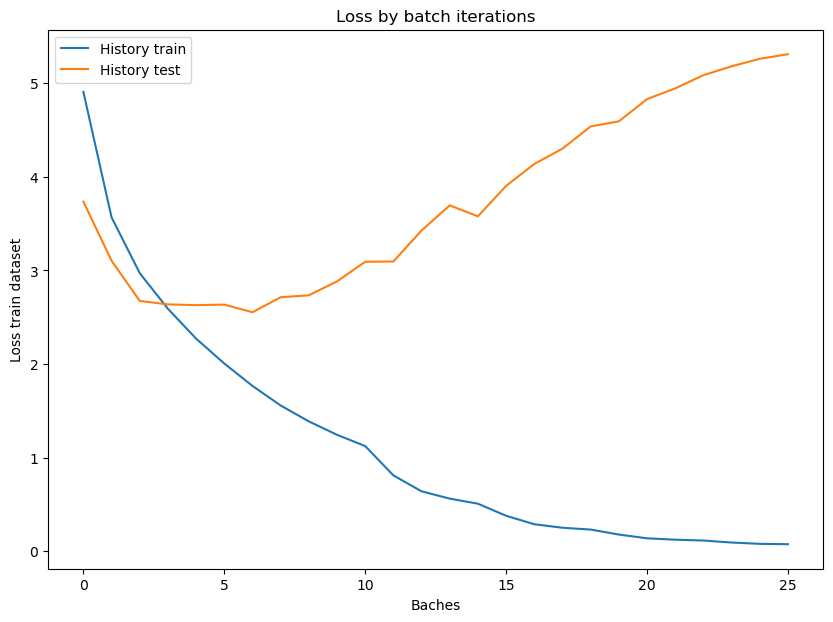

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(history, label = 'History train')
plt.plot(history_test, label = 'History test')
plt.title('Loss by batch iterations')
plt.ylabel('Loss train dataset')
plt.xlabel('Baches')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()

plt.show()

  0%|          | 0/66 [00:01<?, ?it/s]


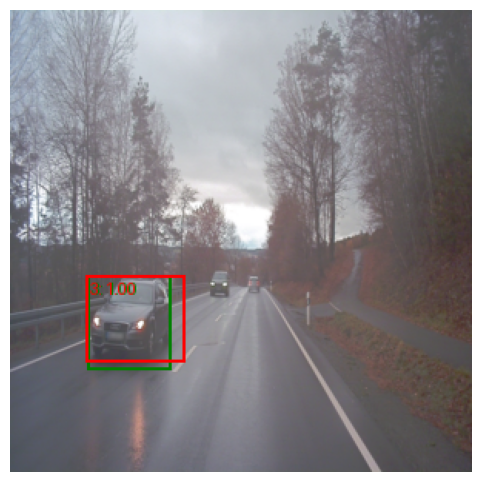

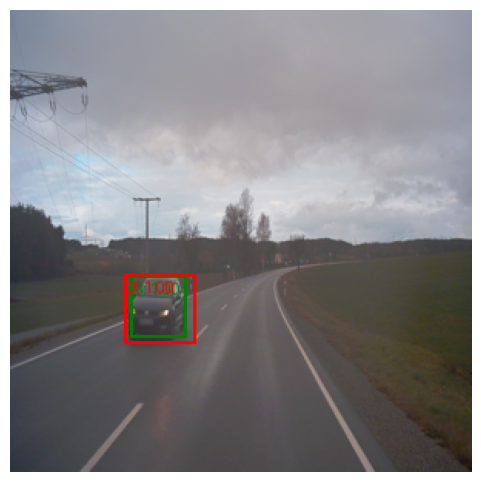

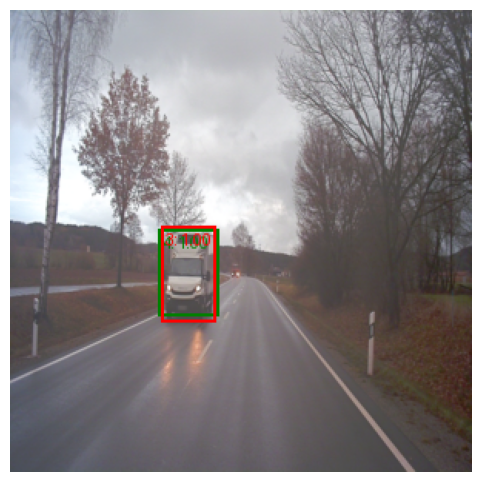

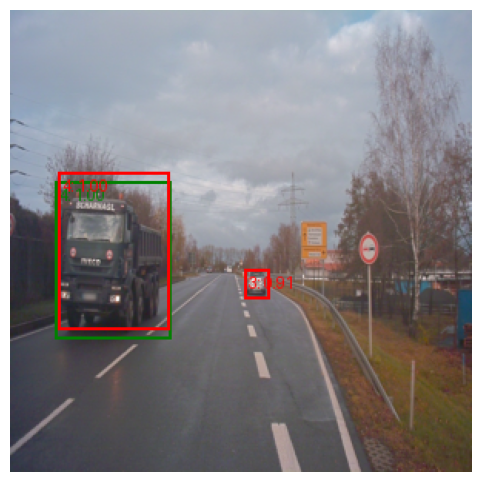

In [26]:
# Визуализация на тест сете
model.eval()
num = 0

for images_test, targets_test in tqdm(test_loader):
    #image = test_images[0].to(device)
    predictions = model(images_test)
    for target in targets_test:
        n = len(target['labels'])
        target['scores'] = torch.ones(n, dtype=torch.float32)
    filtered_preds = apply_nms(predictions)
    visualize_batch_ssd_with_GT(images_test, filtered_preds, targets_test, img_name= f'.\\tests\\SSD\\test_image_bach_{num}', save= True)
    num +=1

    break

In [10]:
checkpoint = torch.load('.\\models\\pitstop_SSD.pth', map_location=device)
    
# Загружаем состояние модели
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [11]:
from tqdm import tqdm

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images_test, targets_test in tqdm(test_loader):
        preds = model(images_test)
        preds = apply_nms(preds)  # твоя фильтрация NMS

        # preds уже список словарей: [{'boxes':..., 'labels':..., 'scores':...}, ...]
        # targets_test — список словарей: [{'boxes':..., 'labels':...}, ...]

        all_preds.extend(preds)
        all_targets.extend(targets_test)

100%|██████████| 66/66 [00:22<00:00,  2.98it/s]


In [14]:
import torch
import numpy as np
from collections import defaultdict
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt


def box_iou(boxes1, boxes2):
    area1 = (boxes1[:, 2] - boxes1[:, 0]).clamp(min=0) * (boxes1[:, 3] - boxes1[:, 1]).clamp(min=0)
    area2 = (boxes2[:, 2] - boxes2[:, 0]).clamp(min=0) * (boxes2[:, 3] - boxes2[:, 1]).clamp(min=0)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  

    wh = (rb - lt).clamp(min=0)  
    inter = wh[..., 0] * wh[..., 1]  

    union = area1[:, None] + area2 - inter
    return inter / union.clamp(min=1e-6)


def collect_class_detections(all_preds, all_targets, class_id, iou_threshold=0.5):
    y_true, y_scores = [], []

    for pred, target in zip(all_preds, all_targets):
        preds_cls = pred['labels'] == class_id
        boxes_pred = pred['boxes'][preds_cls]
        scores_pred = pred['scores'][preds_cls]

        gts_cls = target['labels'] == class_id
        boxes_gt = target['boxes'][gts_cls]

        matched_gt = set()
        for box, score in zip(boxes_pred, scores_pred):
            if len(boxes_gt) > 0:
                ious = box_iou(box.unsqueeze(0), boxes_gt).squeeze(0)
                best_iou, idx = ious.max(0)
                if best_iou >= iou_threshold and idx.item() not in matched_gt:
                    y_true.append(1)
                    matched_gt.add(idx.item())
                else:
                    y_true.append(0)
            else:
                y_true.append(0)

            y_scores.append(score.item())

        # FN для оставшихся GT
        for _ in range(len(boxes_gt) - len(matched_gt)):
            y_true.append(1)
            y_scores.append(0.0)

    return np.array(y_true), np.array(y_scores)


def evaluate_map(all_preds, all_targets, class_ids, iou_threshold=0.5, plot_classes=None):
    aps = {}
    pr_curves = {}  # тут будем хранить кривые: {class_id: (precision, recall)}

    for cid in class_ids:
        y_true, y_scores = collect_class_detections(all_preds, all_targets, cid, iou_threshold)

        if len(np.unique(y_true)) < 2:
            continue

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ap = auc(recall, precision)
        aps[cid] = ap
        pr_curves[cid] = (precision, recall)

        if plot_classes and cid in plot_classes:
            plt.plot(recall, precision, label=f"Class {cid} (AP={ap:.3f})")

    if plot_classes:
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall curves")
        plt.legend()
        plt.grid()
        plt.show()

    mAP = np.mean(list(aps.values())) if aps else 0.0
    return mAP, aps, pr_curves

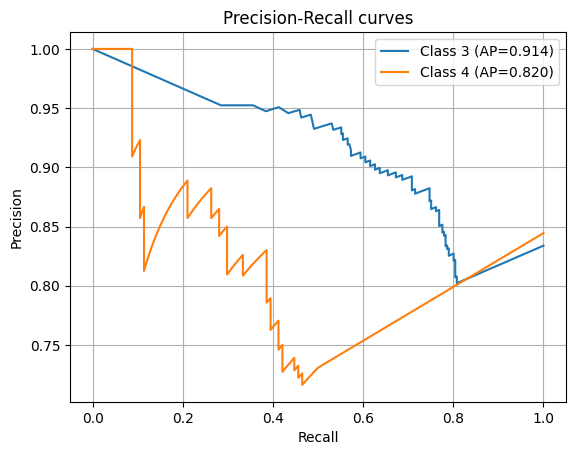

mAP: 0.8671214913945064
APs по классам: {3: 0.9143833839760445, 4: 0.8198595988129684}


In [15]:
# После инференса (как у тебя в коде):
# all_preds, all_targets собраны

class_ids = [3, 4]   # интересующие классы
mAP, aps, pr = evaluate_map(all_preds, all_targets, class_ids, iou_threshold=0.5, plot_classes=[3, 4])

print("mAP:", mAP)
print("APs по классам:", aps)

In [16]:
np.savez(".\\results_2d_detection\\pr_curves\\pr_curves_ssd_classic.npz", **{str(k): v for k,v in pr.items()})